In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from statsmodels.tsa.stattools import acf
import datetime
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler

### Load Data

In [2]:
path = '../data-sets/KPI/'
train = pd.read_csv(path+'train-data.csv')
test = pd.read_hdf(path+"test-data.hdf")
test['KPI ID'] = test['KPI ID'].astype(str)
print(train.shape),print(test.shape)
train.head()

(3004066, 4)
(2918847, 4)


,timestamp,value,label,KPI ID
0,1476460800,0.012604,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
1,1476460860,0.017786,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
2,1476460920,0.012014,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
3,1476460980,0.017062,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
4,1476461040,0.023632,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd


### Check how many different time-series data & # of values for each

In [3]:
train.groupby('KPI ID').count()

,timestamp,value,label
KPI ID,,,
05f10d3a-239c-3bef-9bdc-a2feeb0037aa,146255,146255,146255
0efb375b-b902-3661-ab23-9a0bb799f4e3,8784,8784,8784
1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0,146254,146254,146254
301c70d8-1630-35ac-8f96-bc1b6f4359ea,8784,8784,8784
42d6616d-c9c5-370a-a8ba-17ead74f3114,146253,146253,146253
43115f2a-baeb-3b01-96f7-4ea14188343c,108071,108071,108071
431a8542-c468-3988-a508-3afd06a218da,129046,129046,129046
4d2af31a-9916-3d9f-8a8e-8a268a48c095,128872,128872,128872
54350a12-7a9d-3ca8-b81f-f886b9d156fd,8866,8866,8866


### Deal with Label imbalance

In [4]:
nums_zero = train.groupby('KPI ID')['label'].size() - train.groupby('KPI ID')['label'].sum()
nums_one = train.groupby('KPI ID')['label'].sum()
kpi_id = list(train.groupby('KPI ID').indices.keys())

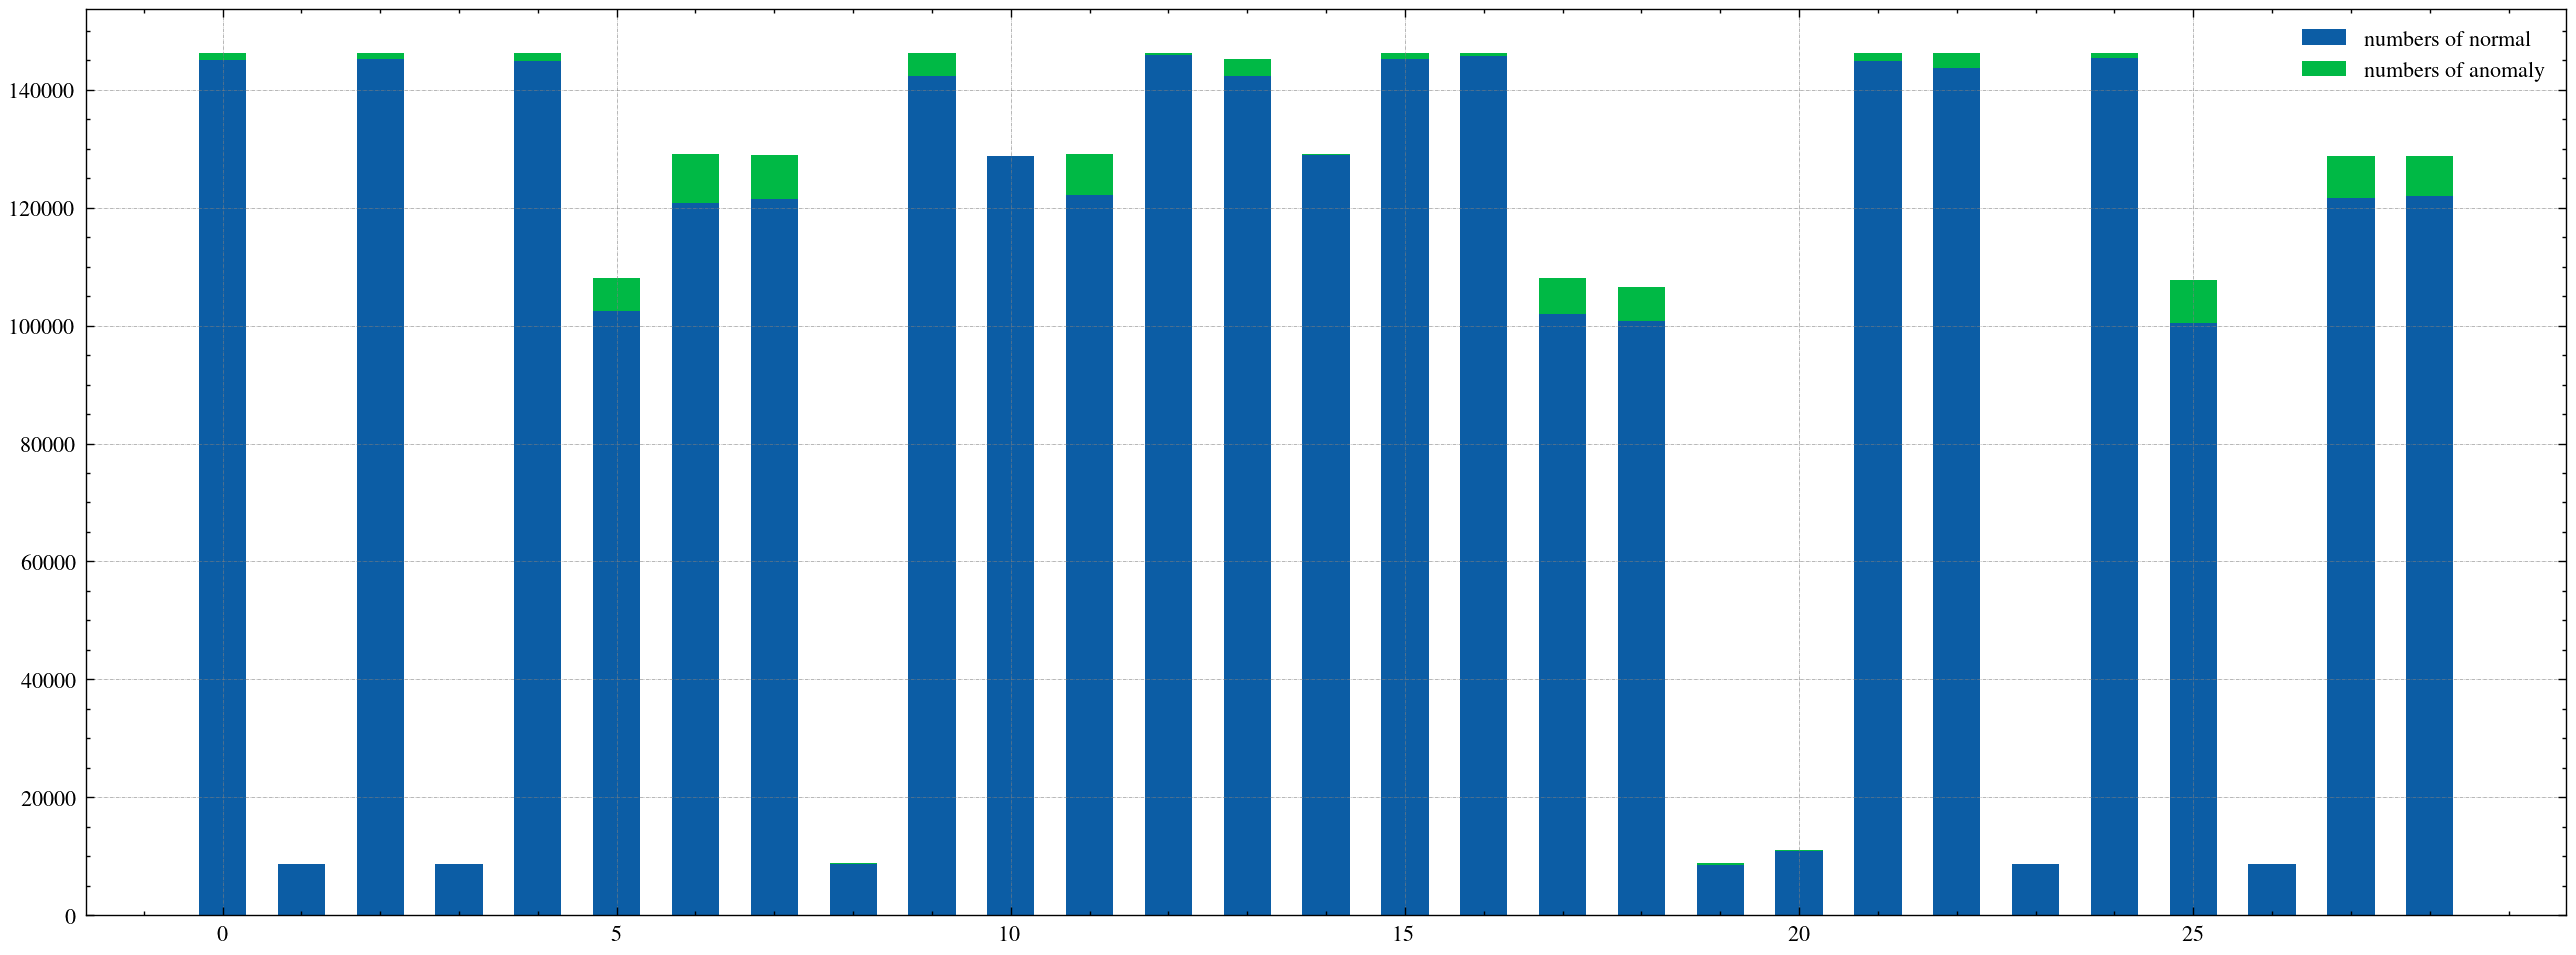

In [5]:
plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[16,6],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)

plt.bar(range(len(kpi_id)),nums_zero,width=0.6,label = 'numbers of normal')
plt.bar(range(len(kpi_id)),nums_one,bottom=nums_zero,width=0.6,label = 'numbers of anomaly')
plt.legend()

In [4]:
def get_week_of_month(year, month, day):
    begin = int(datetime.date(year, month, 1).strftime("%W"))
    end = int(datetime.date(year, month, day).strftime("%W"))

    return end - begin + 1
def extract_time_stamp(ts):
    string = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    year,month,day,hour = int(string[0:4]),int(string[5:7]),int(string[8:10]),int(string[11:13])
    
    week_of_month = get_week_of_month(year,month,day)
    
    if 0 <= hour <= 6:
        time_period = 'EarlyMorning'
    elif 6< hour <= 12:
        time_period = 'Morning'
    elif 12 < hour <= 18:
        time_period = 'Afternoon'
    else:
        time_period = 'Night'
    
    return week_of_month,time_period

def cal_period(data):
    fft_series = fft(data)
    power = np.abs(fft_series)
    sample_freq = fftfreq(fft_series.size)

    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    powers = power[pos_mask]

    top_k_seasons = 3

    # top K=5 index
    top_k_idxs = np.argpartition(powers, -top_k_seasons)[-top_k_seasons:]
    top_k_power = powers[top_k_idxs]
    fft_periods = (1 / freqs[top_k_idxs]).astype(int)
    
    # Expected time period
    scores = []
    for lag in fft_periods:
        # lag = fft_periods[np.abs(fft_periods - time_lag).argmin()]
        acf_score = acf(data, nlags=lag)[-1]
        scores.append(acf_score)
        # print(f"lag: {lag} fft acf: {acf_score}")
        
    period = fft_periods[scores.index(max(scores))] #candidated periods with highest acf score
    
    return period

# Generated training sequences for use in the model.
def create_sequences(df, time_steps):
    output = []
    for i in range(len(df) - time_steps + 1):
        x = np.array(df[i:i+time_steps])
        x[-1,-1] = 0 #the last label should not be known
        output.append(x)
    return np.stack(output)

def get_model(period,feature):
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=7, activation='elu', padding='same',input_shape=(period,feature)))
    model.add(layers.Conv1D(filters=32, kernel_size=7, activation='elu',padding='same'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(8, activation='elu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 10
    end_lr = 0.00001
    lrate = initial_lrate * np.power(drop,  
        np.floor((1+epoch)/epochs_drop))
    if lrate > end_lr:
        return lrate
    else:
        return end_lr

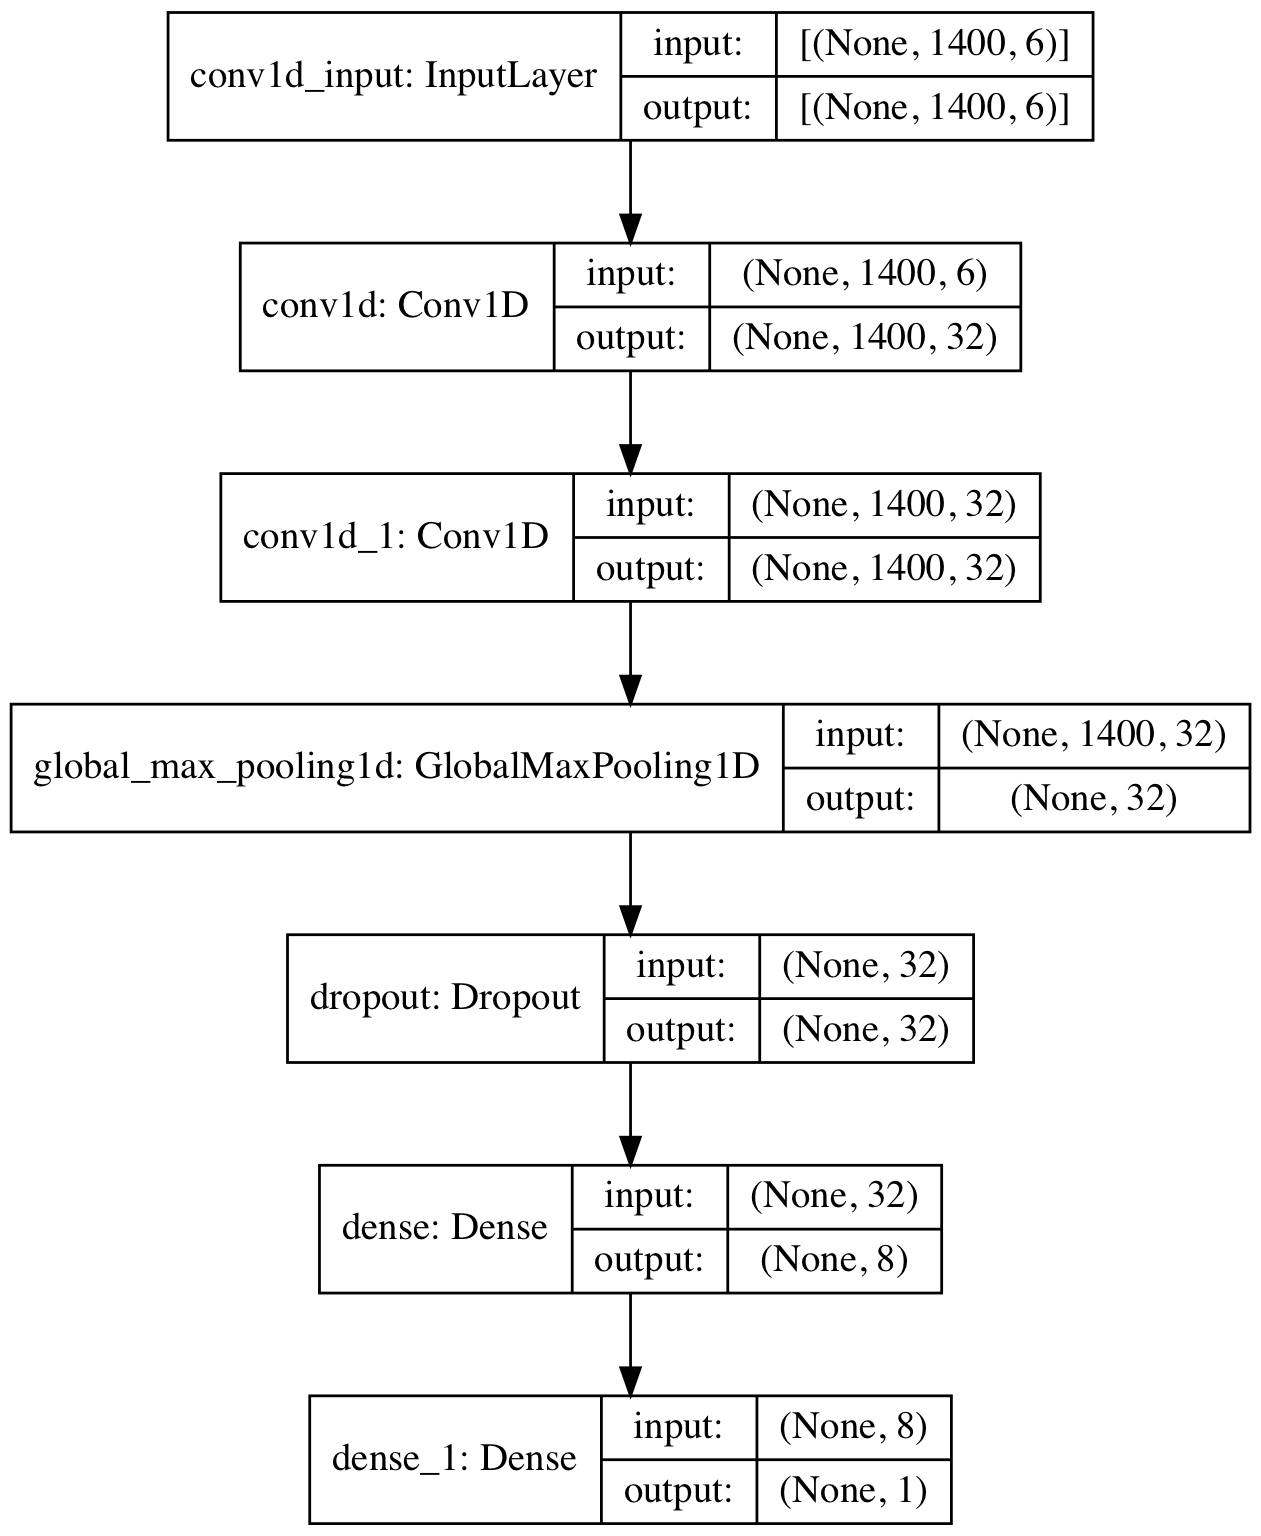

In [5]:
dot_img_file = 'model.png'
keras.utils.plot_model(get_model(1400,6), to_file=dot_img_file, show_shapes=True,dpi=200)

In [20]:
unique_kid = train['KPI ID'].unique().tolist()
TRUE = np.array([])
TRUE_PRED = np.array([])
for kid in unique_kid:
    partial_train = train[train['KPI ID'] == kid]
    partial_train = partial_train.reset_index().drop(['index'],axis=1)
    
    ##data engineering
    partial_train['week_of_month'],partial_train['time_period'] = zip(*partial_train['timestamp'].map(extract_time_stamp))
    
    ## normalization
    mean,std = partial_train['value'].mean(),partial_train['value'].std()
    
    partial_train['value'] = (partial_train['value']-mean)/std
    
    ##
    period = cal_period(np.array(partial_train['value']))
    
    ## define trainning data
    x_train = partial_train[[i for i in partial_train.columns if i not in ['timestamp','label','KPI ID']]]
    x_train = pd.get_dummies(x_train)
    num_of_features = x_train.shape[1]
    # x_train = create_sequences(x_train, period)
    y_train = partial_train['label']
     
    
    ##build model
    clf = RandomForestClassifier(n_estimators=300,class_weight={0:.01,1:.99})
    clf.fit(x_train, y_train)
#     model = get_model(period,num_of_features)
#     epochs = 1
#     batch_size = 8
#     lr_scheduler = LearningRateScheduler(step_decay)
#     optimizer = keras.optimizers.Adam(0.01)

#     model.compile(optimizer=optimizer, loss="binary_crossentropy",metrics=['accuracy'])
    
#     model.fit(x_train,y_train,epochs=epochs,
#                             batch_size=batch_size,
#                             validation_split=0.2,
#                             callbacks=[lr_scheduler],
#                             class_weight = {0: .1, 1:.9},
#                             verbose=1)
    
#     del x_train,y_train,partial_train
    
    #predict on test data
     
    partial_test = test[test['KPI ID'] == kid]
    partial_test = partial_test.reset_index().drop(['index'],axis=1)
    
    partial_test['week_of_month'],partial_test['time_period'] = zip(*partial_test['timestamp'].map(extract_time_stamp))
    
    partial_test['value'] = (partial_test['value']-mean)/std
    
    x_test = partial_test[[i for i in partial_test.columns if i not in ['timestamp','label','KPI ID']]]
    x_test = pd.get_dummies(x_test)
    # x_test = create_sequences(x_test, period)
    y_test = partial_test['label']
    
    pred = clf.predict(x_test)
    # threshold = 0.5
    # pred = (pred >= threshold).astype(int)
    # pred = np.squeeze(pred)
    
    print(classification_report(y_test, pred))
    
    
    TRUE_PRED = np.append(TRUE_PRED,pred)
    
    TRUE = np.append(TRUE,np.array(partial_test['label']))

print(classification_report(TRUE, TRUE_PRED))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     98417
           1       0.35      0.26      0.30      8750

    accuracy                           0.90    107167
   macro avg       0.64      0.61      0.62    107167
weighted avg       0.89      0.90      0.89    107167

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8668
           1       0.23      0.50      0.32       116

    accuracy                           0.97      8784
   macro avg       0.61      0.74      0.65      8784
weighted avg       0.98      0.97      0.98      8784

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10593
           1       0.20      0.21      0.20       187

    accuracy                           0.97     10780
   macro avg       0.59      0.60      0.60     10780
weighted avg       0.97      0.97      0.97     10780

              preci